## EDA


In [1]:
import duckdb
import glob
import os

CLEANED_DIR = "/root/Merged-Files"
all_files = glob.glob(os.path.join(CLEANED_DIR, "*_merged.parquet"))

total_rows = 0

for file in all_files:
    print(f"Counting rows in {os.path.basename(file)}")
    try:
        con = duckdb.connect()
        row_count = con.sql(f"SELECT COUNT(*) FROM '{file}'").fetchone()[0]
        print(f"{os.path.basename(file)} → {row_count:,} rows")
        total_rows += row_count
        con.close()
    except Exception as e:
        print(f"Skipped {os.path.basename(file)}: {e}")
        try:
            con.close()
        except:
            pass

print(f"\nTotal rows across all valid files: {total_rows:,}")


Counting rows in Video_Games_merged.parquet
Video_Games_merged.parquet → 4,570,965 rows
Counting rows in Amazon_Fashion_merged.parquet
Amazon_Fashion_merged.parquet → 2,475,694 rows
Counting rows in Arts_Crafts_and_Sewing_merged.parquet
Arts_Crafts_and_Sewing_merged.parquet → 8,876,382 rows
Counting rows in Home_and_Kitchen_merged.parquet
Home_and_Kitchen_merged.parquet → 66,610,259 rows
Counting rows in Baby_Products_merged.parquet
Baby_Products_merged.parquet → 5,967,958 rows
Counting rows in Unknown_merged.parquet
Unknown_merged.parquet → 63,813,972 rows
Counting rows in Electronics_merged.parquet
Electronics_merged.parquet → 43,374,274 rows
Counting rows in CDs_and_Vinyl_merged.parquet
CDs_and_Vinyl_merged.parquet → 4,772,072 rows
Counting rows in Digital_Music_merged.parquet
Digital_Music_merged.parquet → 128,764 rows
Counting rows in Patio_Lawn_and_Garden_merged.parquet
Patio_Lawn_and_Garden_merged.parquet → 16,318,140 rows
Counting rows in Office_Products_merged.parquet
Office_P

In [5]:
import duckdb
import os
import glob

CLEANED_DIR = "/root/cleaned_parquets"
file_paths = glob.glob(os.path.join(CLEANED_DIR, "*_merged.parquet"))

for file in file_paths:
    con = duckdb.connect()

    fixed_df = con.sql(f"""
    SELECT
        *,
        strftime(to_timestamp(CAST(year AS DOUBLE) * 1000),
                '%Y')::INTEGER AS corrected_year
            FROM read_parquet('{file}')
        LIMIT 10
    """).df()

    con.close()

    print(f"\n{os.path.basename(file)}:")
    print(fixed_df[['year', 'corrected_year']])


Electronics_merged.parquet:
   year  corrected_year
0  2018            1970
1  2016            1970
2  2022            1970
3  2022            1970
4  2022            1970
5  2021            1970
6  2021            1970
7  2021            1970
8  2021            1970
9  2021            1970


InvalidInputException: Invalid Input Error: No magic bytes found at end of file '/root/cleaned_parquets/Books_merged.parquet'

Reading Arts_Crafts_and_Sewing_merged.parquet...
                        user_id        asin parent_asin  rating  \
0  AFYIOFE7ZRJFQLVCXLJS5YX5PBUA  B07BWDJMJN  B07BWDJMJN     5.0   
1  AH7CB6NHGGJ5MIGMDB4NWZO57FHA  B07TD91CSB  B07TD91CSB     5.0   
2  AE7WSZXPO336LQEJDYP2ZHUKT5HA  B00BSGKF50  B00BSGKF50     5.0   
3  AGNGWLDHXY4ZCYXGJWHIPQN7UAAQ  B00HS5ADYS  B00HS5ADYS     1.0   
4  AF3UE6SGDUK7FSNFDGOX4NLR3OIQ  B00ADD0LEE  B00ADD0LEE     5.0   

                                                text  verified_purchase  \
0                                          Love it!!               True   
1  Really impressed with how sharp these were. I ...               True   
2  This punch is what I ordered, worked well to p...               True   
3  Too shiny and thin.  Had to cover white leathe...               True   
4  I bought this for my grandson for Christmas. H...               True   

   helpful_vote  review_length   year    brand          main_category  \
0             1         

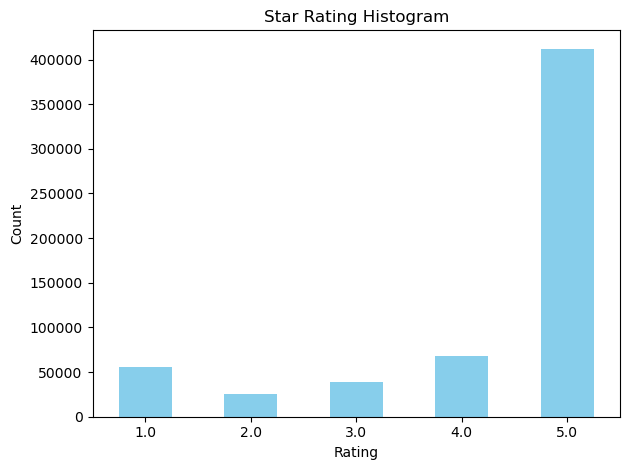

In [3]:
import glob
import os
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

CLEANED_DIR = "/root/Merged"
all_files = glob.glob(os.path.join(CLEANED_DIR, "*_merged.parquet"))

rating_counter = Counter()

for file in all_files:
    print(f"Reading {os.path.basename(file)}...")
    try:
        df = duckdb.sql(f"SELECT * FROM '{file}' LIMIT 50000").df()
        print(df.head())
        
        if 'rating' in df.columns:
            rating_counter.update(df['rating'].value_counts().to_dict())

    except Exception as e:
        print(f"Error reading {file}: {e}")

rating_series = pd.Series(rating_counter)
rating_series.index = pd.to_numeric(rating_series.index, errors='coerce')
rating_series = rating_series.dropna().sort_index()

if rating_series.empty:
    print("No valid rating data to plot.")
else:
    rating_series.plot(kind='bar', title='Star Rating Histogram', color='skyblue')
    plt.xlabel('Rating')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


Analyzing review lengths in Arts_Crafts_and_Sewing_merged.parquet
Analyzing review lengths in Baby_Products_merged.parquet
Analyzing review lengths in CDs_and_Vinyl_merged.parquet
Analyzing review lengths in Digital_Music_merged.parquet
Analyzing review lengths in Beauty_and_Personal_Care_merged.parquet
Analyzing review lengths in Clothing_Shoes_and_Jewelry_merged.parquet
Analyzing review lengths in Automotive_merged.parquet
Analyzing review lengths in Gift_Cards_merged.parquet
Analyzing review lengths in All_Beauty_merged.parquet
Analyzing review lengths in Cell_Phones_and_Accessories_merged.parquet
Analyzing review lengths in Books_merged.parquet
Analyzing review lengths in Appliances_merged.parquet


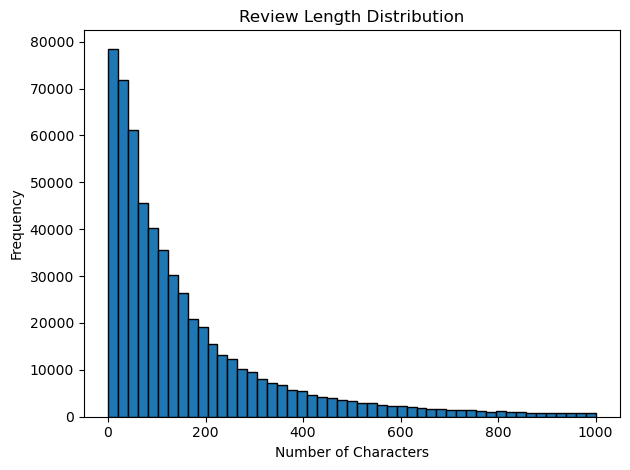

In [4]:
import glob
import os
import duckdb
import numpy as np
import matplotlib.pyplot as plt

CLEANED_DIR = "/root/Merged"
all_files = glob.glob(os.path.join(CLEANED_DIR, "*_merged.parquet"))

lengths = []

for file in all_files:
    print(f"Analyzing review lengths in {os.path.basename(file)}")

    try:
        df = duckdb.sql(f"SELECT text FROM '{file}' WHERE text IS NOT NULL LIMIT 50000").df()
        if 'text' in df.columns:
            lengths.extend(df['text'].dropna().str.len().tolist())
    except Exception as e:
        print(f"Error in {file}: {e}")

if lengths:
    plt.hist(lengths, bins=np.linspace(0, 1000, 50), edgecolor='black')
    plt.title("Review Length Distribution")
    plt.xlabel("Number of Characters")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()
else:
    print("No review text lengths found to plot.")


In [5]:
import glob
import os
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter


CLEANED_DIR = "/root/Merged"
all_files = glob.glob(os.path.join(CLEANED_DIR, "*_merged.parquet"))

brand_counter = Counter()

for file in all_files:
    print(f"Counting brands in {os.path.basename(file)}")

    try:
        df = duckdb.sql(f"""
            SELECT brand FROM '{file}'
            WHERE brand IS NOT NULL AND brand != 'Unknown'
            LIMIT 50000
        """).df()

        if 'brand' in df.columns:
            brand_counter.update(df['brand'].value_counts().to_dict())

    except Exception as e:
        print(f"Error reading {file}: {e}")


top_brands = pd.Series(brand_counter).sort_values(ascending=False).head(10)
top_brands.plot(kind='barh', title='Top 10 Brands by Review Count', color='goldenrod')
plt.xlabel('Count')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Counting brands in Arts_Crafts_and_Sewing_merged.parquet
Counting brands in Baby_Products_merged.parquet
Counting brands in CDs_and_Vinyl_merged.parquet
Counting brands in Digital_Music_merged.parquet
Counting brands in Beauty_and_Personal_Care_merged.parquet
Counting brands in Clothing_Shoes_and_Jewelry_merged.parquet
Counting brands in Automotive_merged.parquet
Counting brands in Gift_Cards_merged.parquet
Counting brands in All_Beauty_merged.parquet
Counting brands in Cell_Phones_and_Accessories_merged.parquet
Counting brands in Books_merged.parquet
Counting brands in Appliances_merged.parquet


TypeError: no numeric data to plot

Analyzing categories in Arts_Crafts_and_Sewing_merged.parquet
Analyzing categories in Baby_Products_merged.parquet
Analyzing categories in CDs_and_Vinyl_merged.parquet
Analyzing categories in Digital_Music_merged.parquet
Analyzing categories in Beauty_and_Personal_Care_merged.parquet
Analyzing categories in Clothing_Shoes_and_Jewelry_merged.parquet
Analyzing categories in Automotive_merged.parquet
Analyzing categories in Gift_Cards_merged.parquet
Analyzing categories in All_Beauty_merged.parquet
Analyzing categories in Cell_Phones_and_Accessories_merged.parquet
Analyzing categories in Books_merged.parquet
Analyzing categories in Appliances_merged.parquet


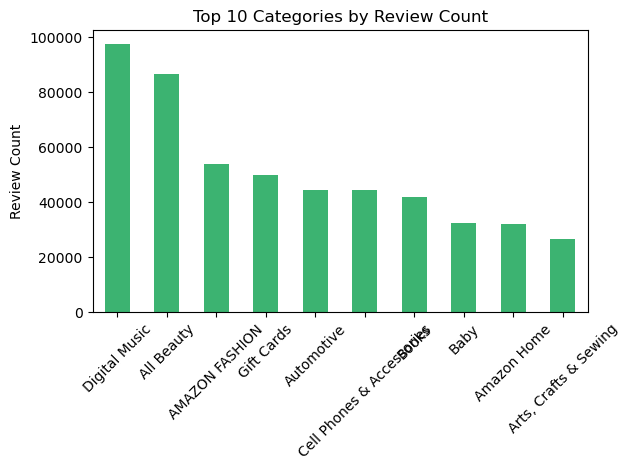

In [6]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

category_counter = Counter()

for file in all_files:
    print(f"Analyzing categories in {os.path.basename(file)}")
    try:
        df = duckdb.sql(f"SELECT main_category FROM '{file}' WHERE main_category IS NOT NULL LIMIT 50000").df()
        category_counter.update(df['main_category'].value_counts().to_dict())
    except Exception as e:
        print(f"Error: {e}")


category_series = pd.Series(category_counter).sort_values(ascending=False).head(10)
category_series.plot(kind='bar', title='Top 10 Categories by Review Count', color='mediumseagreen')
plt.ylabel("Review Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Reading years in Arts_Crafts_and_Sewing_merged.parquet
Reading years in Baby_Products_merged.parquet
Reading years in CDs_and_Vinyl_merged.parquet
Reading years in Digital_Music_merged.parquet
Reading years in Beauty_and_Personal_Care_merged.parquet
Reading years in Clothing_Shoes_and_Jewelry_merged.parquet
Reading years in Automotive_merged.parquet
Reading years in Gift_Cards_merged.parquet
Reading years in All_Beauty_merged.parquet
Reading years in Cell_Phones_and_Accessories_merged.parquet
Reading years in Books_merged.parquet
Reading years in Appliances_merged.parquet


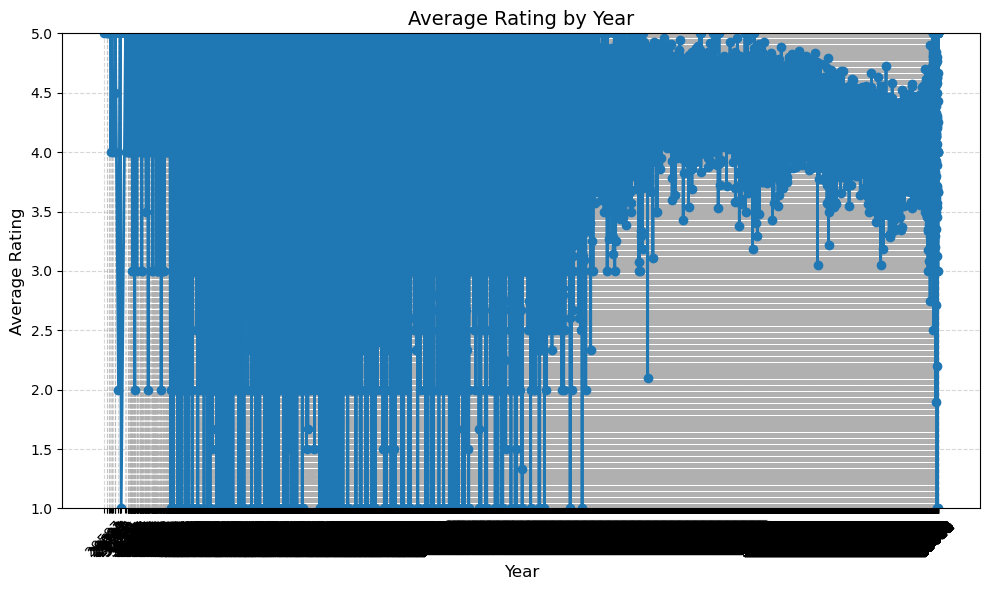

In [10]:

from collections import defaultdict

# Aggregation
sum_by_year = defaultdict(float)
count_by_year = defaultdict(int)

for file in all_files:
    print(f"Reading years in {os.path.basename(file)}")
    try:
        df = duckdb.sql(
            f"SELECT year, rating FROM '{file}' WHERE year IS NOT NULL AND rating BETWEEN 1 AND 5 LIMIT 50000"
        ).df()
        grouped = df.groupby("year")["rating"].agg(["sum", "count"])
        for year, row in grouped.iterrows():
            sum_by_year[year] += row["sum"]
            count_by_year[year] += row["count"]
    except Exception as e:
        print(f"Error in {file}: {e}")

# Prepare data
years = sorted(sum_by_year.keys())
avg_ratings = [round(sum_by_year[y] / count_by_year[y], 3) for y in years]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(years, avg_ratings, marker='o', linestyle='-', linewidth=2, markersize=6)
plt.title("Average Rating by Year", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Average Rating", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(years, rotation=45)
plt.ylim(1, 5)
plt.tight_layout()
plt.show()


In [11]:
brand_counter = Counter()

for file in all_files:
    print(f"Counting brands in {os.path.basename(file)}")
    try:
        df = duckdb.sql(f"SELECT brand FROM '{file}' WHERE brand IS NOT NULL AND brand != 'Unknown' LIMIT 50000").df()
        brand_counter.update(df['brand'].value_counts().to_dict())
    except Exception as e:
        print(f"Error: {e}")

brand_series = pd.Series(brand_counter).sort_values(ascending=False).head(10)
brand_series.plot(kind='bar', title='Top 10 Brands by Review Count', color='coral')
plt.ylabel("Review Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Counting brands in Arts_Crafts_and_Sewing_merged.parquet
Counting brands in Baby_Products_merged.parquet
Counting brands in CDs_and_Vinyl_merged.parquet
Counting brands in Digital_Music_merged.parquet
Counting brands in Beauty_and_Personal_Care_merged.parquet
Counting brands in Clothing_Shoes_and_Jewelry_merged.parquet
Counting brands in Automotive_merged.parquet
Counting brands in Gift_Cards_merged.parquet
Counting brands in All_Beauty_merged.parquet
Counting brands in Cell_Phones_and_Accessories_merged.parquet
Counting brands in Books_merged.parquet
Counting brands in Appliances_merged.parquet


TypeError: no numeric data to plot

In [ ]:
import glob
import os
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

# Path to your cleaned parquet folder
CLEANED_DIR = "/root/Merged"
all_files = glob.glob(os.path.join(CLEANED_DIR, "*_merged.parquet"))

lengths = []
ratings = []

for file in all_files:
    print(f"Sampling from {os.path.basename(file)}")

    try:
        df = duckdb.sql(f"""
            SELECT rating, text FROM '{file}'
            WHERE rating IS NOT NULL AND text IS NOT NULL
            LIMIT 100000
        """).df()

        lengths.extend(df['text'].str.len().tolist())
        ratings.extend(df['rating'].tolist())

    except Exception as e:
        print(f"Error: {e}")

# Compute correlation
if lengths and ratings:
    corr = pd.Series(lengths).corr(pd.Series(ratings))
    print(f"Pearson correlation between review length and rating: {corr:.4f}")

    # Optional: Visualize the trend with scatter
    plt.scatter(lengths, ratings, alpha=0.05)
    plt.title("Review Length vs Star Rating")
    plt.xlabel("Review Length (characters)")
    plt.ylabel("Rating")
    plt.tight_layout()
    plt.show()
else:
    print("Not enough data to compute correlation.")
